# Implicit Solvent Sample-Based Quantum Diagonalization

*Usage estimate: 10 seconds on ibm_torino (NOTE: This is an estimate only. Your runtime might vary.)*

Challenge Based on [*Implicit Solvent Sample-Based Quantum Diagonalization* - J. Phys. Chem. B 2023, 127 (21), 4471–4482.](https://pubs.acs.org/doi/10.1021/acs.jpcb.5c01030)

The recent work, $\textit{Implicit Solvent Sample-Based Quantum Diagonalization}$, directly addressed the question: “Can Sample-Based Quantum Diagonalization energy calculations be reliably integrated with established classical solvation models to reproduce the outcomes of classical energy computations for the simplest biologically relevant polar molecules?” Their findings demonstrate that the answer is a resounding yes.

But a pressing question yet to be answered within scientific literature is "Within the solute-solvent computational context, can SQD add value beyond the established classical routines?" 

This notebook provides a scaling roadmap for SQD-based Quantum Chemistry experiments implemented on real quantum hardware from small-scale, classically simulable cases to large-scale, utility grade demonstrations. By the successful completion of all stages, you will be at the liminal boundary of State-of-the-Art, Utility-Scale Quantum Chemistry experimentation on Quantum Computers.



<div class="alert alert-block alert-success">

## **Contents of this Notebook**:

## **Challenge**: Methylamine, $CH_{3}NH_{2}$ 

### Participants must implement code in several sections to score points

 1. **Hartree-Fock Implementation** : (local execution)

    Changes needed in this notebook `.\ch2_implicit_solvent.ipynb`

 2. **Classical implementation**    :  (remote execution)  : Qiskit Serverless

    Changes needed in this notebook `.\ch2_implicit_solvent.ipynb`

    Changes needed in `.\source_files\classical_simulation.py`

 3. **Quantum implementation**      :  (remote execution)  : Qiskit Runtime, Qiskit Serverless
 
    Changes needed in this notebook `.\ch2_implicit_solvent.ipynb`

You should draw from the provided reference [Implicit Solvent Sample-Based Quantum Diagonalization](https://pubs.acs.org/doi/10.1021/acs.jpcb.5c01030) to guide your selections in this exploration.

</div>

<div class="alert alert-block alert-warning">

## **Challenge Rules**
1.  You need to save a final plotted image using the provided function in order for your team's score to be considered valid.
2.  You need to save your results using the `results.json` file output by the provided `report_results()` function in order for your team's score to be considered valid.

</div>

<div class="alert alert-block alert-success">

# Challenge instructions: Molecule of Methylamine

### Your tasks

Implement code to perform a small-scale example that demonstrates the CASCI/IEF-PCM(cc-pVDZ) vs SQD/IEF-PCM(cc-pVDZ) workflow on acqueous Methylamine to compute solute-solvent interactions by following directions and filling in code below. Look for the `# PROMPT` marker inside the code boxes to find the places where code needs to be filled in. Where needed, there are specific `# BEGIN ANSWER` and `# END ANSWER` markers as well. Completing the notebook by filling in the prompts will lead to a basic implementation that has a few simplifications relative to the implementation in [Implicit Solvent Sample-Based Quantum Diagonalization](https://pubs.acs.org/doi/pdf/10.1021/acs.jpcb.5c01030?ref=article_openPDF).

## Grading system (100 points):
### Ex.1: Obtaining the Restricted Hartree Fock energy (20 points) 
### Ex.2: Obtaining the correct CASCI classical baseline (30 points) 
### Ex.3: Obtaining the correct SQD-based value (up to 50 points)
<div>


## Python imports

We assume that we start from a Python environment that has been initialized by following the instructions.

In [1]:
import pyscf
from pyscf import gto   # Deals with molecular initialization
from pyscf import scf   # Solvation methods
from pyscf import mcscf # More computational solvation methods
from pyscf.solvent import pcm
from qiskit_ibm_catalog import QiskitFunction, QiskitServerless
from qiskit_ibm_runtime import QiskitRuntimeService

Import the grader functions and submit the team name to which your points should be assigned:

In [2]:
from grader_ch2 import (challenge2, grader_ch2_ex1, grader_ch2_ex2, grader_ch2_ex3 )
# PROMPT Define your team name
YOUR_TEAM_NAME = "r2p_converters"
challenge2.submit_name(YOUR_TEAM_NAME)

Grading your answer. Please wait...
Team name submitted.


### Initialize your results file

In [3]:
# Call this cell to initialize your results file. Be careful not to call this when you don't want to! Calling it several times will overwrite your results!
from utils.helpers import init_results_file

while True:
    print("Do you want to initialize a new results file? (y/n)")
    answer = input()
    if answer == "y":
        init_results_file()
        break
    elif answer == 'n':
        break

Do you want to initialize a new results file? (y/n)


<div class="alert alert-block alert-warning">

## **Excercise 1**: Methylamine - Restricted Hartree-Fock
20 Points

</div>

### Initialize the molecule object by using known $\textit{a priori}$ molecular geometry

In [ ]:
# Retrieve molecular geometries from:
# - option 1: https://pubchem.ncbi.nlm.nih.gov
# - option 2: somewhere else of your choosing
 

molecule_name = 'Methylamine'
# PROMPT: Define the geometry
methylamine_geo = """
    N   -0.7154    0.0000    0.0000;
    C    0.7154    0.0000    0.0000;
    H    1.1069    0.0916    1.0174;
    H    1.0996    0.8349   -0.5930;
    H    1.0996   -0.9274   -0.4345;
    H   -1.0625    0.8564    0.4294;
    H   -1.0625   -0.7661    0.5753;
"""
# Got structure from: https://pubchem.ncbi.nlm.nih.gov/compound/6329#section=3D-Conformer

In [6]:
# Explicitly defining the Methylamine molecule
mol = gto.M()
mol.atom = methylamine_geo
# PROMPT: Define the properties
# BEGIN ANSWER
mol.basis = '6-31g'
mol.unit = 'Angstrom'
mol.charge = 0
mol.spin = 0
mol.verbose = 4
# END ANSWER

#Used https://pyscf.org/user/gto.html

mol.build()

### Define solvation effects by using the polarizable continuum model (PCM)

In [7]:
# Retrieve dielectric parameters from: https://gaussian.com/scrf/

# PROMPT:
eps_water = 78.3553

In [9]:
cm = pcm.PCM(mol)
cm.eps = eps_water
# PROMPT:
cm.method = "IEFPCM"

In [10]:
from pyscf import scf   # Self-Consistent Field methods

# Creating a "Restricted Hartree Fock" object for the solute, then wrapping the SCF object with a Polarizable Continuum Model
mf_pcm0 = scf.RHF(mol).PCM(cm) # Restricted Hartree Fock misses instantaneous correlations, post-HF methods like CCSD, CI, MP2 might be worth exploring

### Geometry optimization by using TRIC

In [11]:
# Geometry optimization with geomeTRIC
from pyscf.geomopt.geometric_solver import optimize # GeomeTRIC under the hood, for geometry optimization
mol_opt = optimize(mf_pcm0, tol_grad=3e-4, verbose=0) # Use geomeTRIC/TRIC under the hood

Create scanner for <class 'pyscf.solvent.grad.pcm.PCMGradients'>
Create scanner for <class 'pyscf.solvent._attach_solvent.PCMRHF'>


geometric-optimize called with the following command line:
/home/picalexs/R2P_Capstone/.venv/lib/python3.12/site-packages/ipykernel_launcher.py --f=/run/user/1000/jupyter/runtime/kernel-v3e8bc1f06139a37a12b9cbb2ad892472d50dc1c2b.json

                                        ())))))))))))))))/                     
                                    ())))))))))))))))))))))))),                
                                *)))))))))))))))))))))))))))))))))             
                        #,    ()))))))))/                .)))))))))),          
                      #%%%%,  ())))))                        .))))))))*        
                      *%%%%%%,  ))              ..              ,))))))).      
                        *%%%%%%,         ***************/.        .)))))))     
                #%%/      (%%%%%%,    /*********************.       )))))))    
              .%%%%%%#      *%%%%%%,  *******/,     **********,      .))))))   
                .%%%%%%/      *%%%%%%,  **   


Geometry optimization cycle 1
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -0.715400   0.000000   0.000000    0.000000  0.000000  0.000000
   C   0.715400   0.000000   0.000000    0.000000  0.000000  0.000000
   H   1.106900   0.091600   1.017400    0.000000  0.000000  0.000000
   H   1.099600   0.834900  -0.593000    0.000000  0.000000  0.000000
   H   1.099600  -0.927400  -0.434500    0.000000  0.000000  0.000000
   H  -1.062500   0.856400   0.429400    0.000000  0.000000  0.000000
   H  -1.062500  -0.766100   0.575300    0.000000  0.000000  0.000000

WARN: Mole.unit (Angstrom) is changed to Bohr

New geometry
   1 N     -0.715400000000   0.000000000000   0.000000000000 AA   -1.351910069514   0.000000000000   0.000000000000 Bohr
   2 C      0.715400000000   0.000000000000   0.000000000000 AA    1.351910069514   0.000000000000   0.000000000000 Bohr
   3 H      1.106900000000   0.091600000000   1.017400000000 AA    2.0917378472

Step    0 : Gradient = 2.170e-02/4.082e-02 (rms/max) Energy = -95.1750071137
Hessian Eigenvalues: 2.30000e-02 5.00000e-02 5.00000e-02 ... 4.08746e-01 4.44983e-01 4.45041e-01



Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -0.729895   0.003562   0.039851   -0.014495  0.003562  0.039851
   C   0.742195   0.002192   0.024259    0.026795  0.002192  0.024259
   H   1.221828   0.089779   0.997722    0.114928 -0.001821 -0.019678
   H   1.102685   0.819819  -0.584662    0.003085 -0.015081  0.008338
   H   1.102692  -0.910981  -0.428952    0.003092  0.016419  0.005548
   H  -1.129160   0.849163   0.400734   -0.066660 -0.007237 -0.028666
   H  -1.129244  -0.764134   0.545649   -0.066744  0.001966 -0.029651
New geometry
   1 N     -0.729894629266   0.003562439900   0.039850570948 AA   -1.379300949104   0.006732035747   0.075306664999 Bohr
   2 C      0.742194713841   0.002191639222   0.024258804870 AA    1.402544740260   0.004141597894   0.045842497313 Bohr
   3 H      1.221827693922   0.089779369685   0.997721898431 AA    2.308919712921   0.169658420340   1.885421136516 Bohr
   4 H

Step    1 : Displace = 6.324e-02/1.163e-01 (rms/max) Trust = 1.000e-01 (=) Grad = 4.400e-03/7.502e-03 (rms/max) E (change) = -95.1779607921 (-2.954e-03) Quality = 0.793
Hessian Eigenvalues: 2.30000e-02 4.83007e-02 5.00000e-02 ... 4.28442e-01 4.45012e-01 4.77349e-01



Geometry optimization cycle 3
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -0.723005   0.004232   0.046967    0.006890  0.000670  0.007117
   C   0.741989   0.002046   0.022789   -0.000206 -0.000145 -0.001470
   H   1.202851   0.090286   1.003733   -0.018977  0.000507  0.006011
   H   1.091251   0.824535  -0.586378   -0.011434  0.004716 -0.001716
   H   1.091236  -0.915954  -0.429818   -0.011456 -0.004973 -0.000866
   H  -1.111598   0.856431   0.395484    0.017563  0.007268 -0.005250
   H  -1.111624  -0.772176   0.541822    0.017620 -0.008041 -0.003827
New geometry
   1 N     -0.723004860339   0.004232082088   0.046967493828 AA   -1.366281172771   0.007997476083   0.088755700092 Bohr
   2 C      0.741988698377   0.002046193236   0.022789014262 AA    1.402155427455   0.003866744814   0.043064995603 Bohr
   3 H      1.202850890445   0.090285913991   1.003733111634 AA    2.273058751630   0.170615650350   1.896780683146 Bohr
   4 H

Step    2 : Displace = 1.506e-02/2.006e-02 (rms/max) Trust = 1.414e-01 (+) Grad = 1.326e-03/2.503e-03 (rms/max) E (change) = -95.1783679419 (-4.071e-04) Quality = 1.135
Hessian Eigenvalues: 2.30000e-02 4.24102e-02 5.00000e-02 ... 4.30360e-01 4.45012e-01 4.52556e-01



Geometry optimization cycle 4
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -0.721610   0.004706   0.052316    0.001395  0.000474  0.005348
   C   0.741484   0.001931   0.021470   -0.000504 -0.000116 -0.001319
   H   1.200779   0.090238   1.003271   -0.002072 -0.000048 -0.000462
   H   1.091271   0.825252  -0.587303    0.000020  0.000718 -0.000925
   H   1.091250  -0.916811  -0.430632    0.000014 -0.000856 -0.000814
   H  -1.111014   0.859092   0.394320    0.000583  0.002661 -0.001165
   H  -1.111059  -0.775009   0.541159    0.000565 -0.002833 -0.000663
New geometry
   1 N     -0.721610198807   0.004706082526   0.052315708701 AA   -1.363645644439   0.008893207093   0.098862361457 Bohr
   2 C      0.741484264531   0.001930512535   0.021469763942 AA    1.401202185638   0.003648139972   0.040571973809 Bohr
   3 H      1.200778706807   0.090238183442   1.003270870286 AA    2.269142892075   0.170525452683   1.895907173594 Bohr
   4 H

Step    3 : Displace = 2.829e-03/5.197e-03 (rms/max) Trust = 2.000e-01 (+) Grad = 5.148e-04/9.840e-04 (rms/max) E (change) = -95.1783909227 (-2.298e-05) Quality = 1.136
Hessian Eigenvalues: 2.29999e-02 2.97262e-02 5.00000e-02 ... 4.30232e-01 4.42665e-01 4.45015e-01



Geometry optimization cycle 5
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -0.720755   0.004937   0.054897    0.000855  0.000231  0.002581
   C   0.741102   0.001995   0.022191   -0.000382  0.000064  0.000721
   H   1.204101   0.090165   1.002632    0.003323 -0.000073 -0.000638
   H   1.089951   0.825137  -0.587466   -0.001320 -0.000116 -0.000163
   H   1.089945  -0.916703  -0.430851   -0.001305  0.000107 -0.000218
   H  -1.111606   0.859716   0.393115   -0.000592  0.000623 -0.001204
   H  -1.111638  -0.775845   0.540081   -0.000579 -0.000837 -0.001078
New geometry
   1 N     -0.720754823265   0.004936919292   0.054896656134 AA   -1.362029218930   0.009329425361   0.103739645247 Bohr
   2 C      0.741101894330   0.001994807505   0.022190743652 AA    1.400479610680   0.003769639856   0.041934428002 Bohr
   3 H      1.204101279795   0.090164683833   1.002632389266 AA    2.275421645050   0.170386558553   1.894700619331 Bohr
   4 H

Step    4 : Displace = 1.912e-03/2.929e-03 (rms/max) Trust = 2.828e-01 (+) Grad = 1.907e-04/3.225e-04 (rms/max) E (change) = -95.1783952700 (-4.347e-06) Quality = 1.195
Hessian Eigenvalues: 2.29990e-02 2.62652e-02 5.00000e-02 ... 4.40305e-01 4.44135e-01 4.45014e-01



Geometry optimization cycle 6
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   N  -0.720497   0.005038   0.056109    0.000258  0.000101  0.001213
   C   0.740938   0.001991   0.022072   -0.000163 -0.000004 -0.000119
   H   1.205609   0.090081   1.001827    0.001508 -0.000084 -0.000805
   H   1.089849   0.824938  -0.587859   -0.000102 -0.000199 -0.000393
   H   1.089853  -0.916540  -0.431312   -0.000092  0.000163 -0.000461
   H  -1.112318   0.859643   0.393412   -0.000712 -0.000073  0.000297
   H  -1.112335  -0.775750   0.540351   -0.000696  0.000095  0.000270
New geometry
   1 N     -0.720497016529   0.005038057933   0.056109243539 AA   -1.361542034806   0.009520549693   0.106031103345 Bohr
   2 C      0.740938401404   0.001991291316   0.022071793672 AA    1.400170653826   0.003762995222   0.041709645118 Bohr
   3 H      1.205609148368   0.090080504211   1.001827033933 AA    2.278271103686   0.170227482122   1.893178718320 Bohr
   4 H

Step    5 : Displace = 7.480e-04/1.119e-03 (rms/max) Trust = 3.000e-01 (+) Grad = 3.031e-05/5.591e-05 (rms/max) E (change) = -95.1783958627 (-5.927e-07) Quality = 1.059
Hessian Eigenvalues: 2.29990e-02 2.62652e-02 5.00000e-02 ... 4.40305e-01 4.44135e-01 4.45014e-01
Converged! =D

    #==========================================================================#
    #| If this code has benefited your research, please support us by citing: |#
    #|                                                                        |#
    #| Wang, L.-P.; Song, C.C. (2016) "Geometry optimization made simple with |#
    #| translation and rotation coordinates", J. Chem, Phys. 144, 214108.     |#
    #| http://dx.doi.org/10.1063/1.4952956                                    |#
    #==========================================================================#
    Time elapsed since start of run_optimizer: 30.363 seconds
Hessian Eigenvalues: 2.29990e-02 2.62652e-02 5.00000e-02 ... 4.40305e-01 4.44135e-01 4.450

### Compute the restricted Hartree-Fock energy


In [12]:
# Run the kernel to get the RHF energy
mf_opt = scf.RHF(mol_opt).PCM(cm)
hf_e = float(mf_opt.kernel())



******** <class 'pyscf.solvent._attach_solvent.PCMRHF'> ********
method = PCMRHF
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
******** <class 'pyscf.solvent._attach_solvent.PCMRHF'> ********
method = PCMRHF
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
diis_damp = 0
SCF conv_tol = 1e-09
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /tmp/tmpis5bqgnc
max_memory 4000 MB (current use 587 MB)
******** <class 'pyscf.solvent.pcm.PCM'> (In testing) ********

WARN: PCM is an experimental feature. It is still in testing.
Features and APIs may be changed in the future.

lebedev_order = 29 (302 grids per sphere)
eps = 78.3553
frozen = False
Set gradient conv threshold to 3.16228e-05
Initial guess from minao.
PCM E_diel = -0.000208459471661243
Solvent Energy = -

In [13]:
print(f"Restricted Hartree-Fock Energy: {hf_e}")

Restricted Hartree-Fock Energy: -95.17839586274371


<div class="alert alert-block alert-danger">

## Record your restricted Hartree-Fock results

To report your results, use the function $report\_result()$. You can put your finalized classical energy and quantum energy values for each respective molecule. Every time you finish a molecule, make sure to put your answers into the `report_result` function, which will write them to a `results.json` file that will be used to compute your score. 

</div>

In [14]:
from utils.helpers import report_result

# Overwrite current data in results.json (be careful, and save a backup file if uncertain)
report_result(molecule_name=molecule_name, hartree_fock_E=hf_e, casci_E=None, sqd_E=None)

In [15]:
# Check your grade
grader_ch2_ex1(molecule_name=molecule_name, hartree_fock_E=hf_e)

Grading your answer. Please wait...

Congratulations 🎉! Your answer is correct.
Your score is 0.0.


<div class="alert alert-block alert-success">
Good job! You've finished Excercise 1!
</div>

<div class="alert alert-block alert-warning">

## **Excercise 2**: Methylamine CASCI/(cc-pVDZ) IEF-PCM (by using Qiskit Serverless)
30 Points

</div>

### **Qiskit Serverless**:

Qiskit Serverless is a framework for running distributed quantum and classical workloads without managing infrastructure. There is no server provisioning (no spinning up EC2s, clusters, Docker containers), no orchestration tools (Kubernetes, Docker Swarm), no monitoring/maintenance, etc. Each job run through serverless runs in a clean container, executes your code, and then shuts down. There is no memory between jobs. You just write your code, define dependencies, and submit your job.

Qiskit Serverless gives a user access to always-on remote CPU cores and memory, allowing certain classical workloads to be distributed across the remote resources and to gain some advantage in parallel program processing while avoiding common headaches from device shutdown mid-execution.

In summary, Qiskit Serverless has these benefits:

1) Is it an always-on remote environment.
2) It has mltiple remote CPU cores, allowing us to distribute computation efficiently across parallel resources.

In [16]:
# Establish Qiskit Runtime connection
client = QiskitServerless(name="r2p-2025")

<div class="alert alert-block alert-warning">

Visit `./source_files/classical_simulation.py` and fill in the code (based on Excercise 1) to complete this section.

</div>

In [17]:
# We need to share the program intended to run in the cloud environment, and re-upload it any time we change it's source code
client.upload(
    QiskitFunction(
        title="classical_simulation",
        entrypoint="classical_simulation.py", # lives in ./source_files
        working_dir="source_files"))

QiskitFunction(classical_simulation)

In [18]:
# Setup a Serverless Client
worker = client.load("classical_simulation")

In [19]:
from json.encoder import JSONEncoder
# PROMPT: Get the labels from Table 1 of the paper
ao_labels = ['C 2s', 'C 2p', 'N 2s', 'N 2p', 'H 1s']
data_e = JSONEncoder().encode([mol_opt.tostring(), eps_water, ao_labels])

In [20]:
serverless_job = worker.run(data=data_e)

In [21]:
from utils.helpers import feedback_serverless
# Optionally, check the Serverless status feedback
# Don't sit here and stare at the feedback unless debugging. You can go develop something else while the Serverless job runs.
_ = feedback_serverless(serverless_job)

>>>>> Serverless status: 14853e92-04f3-442c-89e0-383861fb5ecb
>>>>> [0s] Serverless job 14853e92-04f3-442c-89e0-383861fb5ecb:                 QUEUED
>>>>> [10s] Serverless job 14853e92-04f3-442c-89e0-383861fb5ecb:                 QUEUED
>>>>> [20s] Serverless job 14853e92-04f3-442c-89e0-383861fb5ecb:                 QUEUED
>>>>> [30s] Serverless job 14853e92-04f3-442c-89e0-383861fb5ecb:                 RUNNING
>>>>> [40s] Serverless job 14853e92-04f3-442c-89e0-383861fb5ecb:                 RUNNING
>>>>> [50s] Serverless job 14853e92-04f3-442c-89e0-383861fb5ecb:                 RUNNING
>>>>> [60s] Serverless job 14853e92-04f3-442c-89e0-383861fb5ecb:                 RUNNING
>>>>> [70s] Serverless job 14853e92-04f3-442c-89e0-383861fb5ecb:                 RUNNING
>>>>> Serverless job 14853e92-04f3-442c-89e0-383861fb5ecb: DONE


In [ ]:
#If you make a mistake and need to cancel something
# for job in client.jobs():
#     job.cancel()

In [22]:
from json.decoder import JSONDecoder
CASCI_E = JSONDecoder().decode(serverless_job.result()['outputs'])[0]

In [23]:
# We have approximated the red, classical baseline from Figure 1 for Methanol (North-West panel)
print(f"CASCI/IEF-PCM(cc-pVDZ): E={CASCI_E}")

CASCI/IEF-PCM(cc-pVDZ): E=-95.30443886330966


<div class="alert alert-block alert-danger">

### Record your CASCI results

To report your results, use the $report\_result()$ function. You can put your finalized classical energy and quantum energy values for each respective molecule. Every time you finish a molecule, make sure to put your answers into the `report_result` function, which will write them to a `results.json` file that will be used to compute your score. 

</div>

In [24]:
from utils.helpers import report_result

# Overwrite current data in results.json (be careful, and save a backup file if uncertain)
# This is used for plotting at the end
report_result(molecule_name=molecule_name, hartree_fock_E=hf_e, casci_E=CASCI_E, sqd_E=None)

In [25]:
# Check your grade
grader_ch2_ex2(molecule_name, CASCI_E)

Grading your answer. Please wait...

Congratulations 🎉! Your answer is correct.
Your score is 0.0.


<div class="alert alert-block alert-success">
Good job! You've finished Excercise 2!
</div>

<div class="alert alert-block alert-warning">

## **Excercise 3**: Methylamine SQD/(cc-pVDZ) IEF-PCM (by using Qiskit Serverless)
50 Points

</div>

### Establish a Qiskit Runtime connection

In [26]:
# Establish Quantum Resource connection

service = QiskitRuntimeService(name="r2p-2025")
# PROMPT: Choose your prefered backend
backend_name = "ibm_brussels"
backend = service.backend(backend_name, use_fractional_gates=True)
print(f"Using backend {backend.name}")

Using backend ibm_brussels


### Establish a Qiskit Serverless connection (if not done for the classical baseline calculation)

In [27]:
# Establish Classical HPC Resource connection

client = QiskitServerless(name="r2p-2025" )

In [28]:
from pyscf.mcscf import avas

# Re-define the PCM
cm = pcm.PCM(mol_opt)
cm.eps = eps_water # for water
# PROMPT: you can use the same method as before
cm.method = "IEFPCM"

# Re-build the Restricted Hartree Fock object
mf_opt = scf.RHF(mol_opt).PCM(cm)
mf_opt.kernel(verbose=0)

# Run AVAS
# PROMPT: use the same ao_levels as before
ao_labels = ['C 2s', 'C 2p', 'N 2s', 'N 2p', 'H 1s']
avas_ = avas.AVAS(mf_opt, ao_labels, with_iao=True, canonicalize=True, verbose=0)
avas_.kernel()
norb, ne_act, mo_avas = avas_.ncas, avas_.nelecas, avas_.mo_coeff

num_elec_a = (ne_act + mol_opt.spin) // 2
num_elec_b = (ne_act - mol_opt.spin) // 2



******** <class 'pyscf.solvent._attach_solvent.PCMRHF'> ********
method = PCMRHF
initial guess = minao
******** <class 'pyscf.solvent._attach_solvent.PCMRHF'> ********
method = PCMRHF
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
diis_damp = 0
SCF conv_tol = 1e-09
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /tmp/tmp8szglte6
max_memory 4000 MB (current use 592 MB)
******** <class 'pyscf.solvent.pcm.PCM'> (In testing) ********

WARN: PCM is an experimental feature. It is still in testing.
Features and APIs may be changed in the future.

lebedev_order = 29 (302 grids per sphere)
eps = 78.3553
frozen = False
Set gradient conv threshold to 3.16228e-05
Initial guess from minao.
PCM E_diel = -0.000208459471661244
Solvent Energy = -0.000208459471661244
init E= -95.2766438301603
  HOMO = -0.246171887067023  LUMO = 0.162915675532126


In [35]:
from qiskit.transpiler import generate_preset_pass_manager
import ffsim

from utils.sqd_helpers import get_zigzag_physical_layout

# Initial LUCJ ansatz layout
initial_layout, _ = get_zigzag_physical_layout(norb, backend=backend)

# Initialize a pass manager 
# PROMPT: define your basis gates, e.g. ['rx', 'rz', 'cz']
pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=backend, initial_layout=initial_layout
    #, basis_gates=['ecr', 'id', 'rz', 'sx', 'x']
)

pass_manager.pre_init = ffsim.qiskit.PRE_INIT

In [ ]:
#To see backend native gates we used:
print(backend.configuration().basis_gates)


['ecr', 'id', 'rz', 'sx', 'x']


In [36]:
# We need to share the program intended to run in the cloud environment, and re-upload it any time we change it's source code
client.upload(
    QiskitFunction(
        title="diagonalization_engine",
        entrypoint="diagonalization_engine.py", # lives in ./source_files
        working_dir="source_files"))

QiskitFunction(diagonalization_engine)

>>>>> ACTIVE SPACE CALCULATIONS 
Parsing as_fcidump_20:06:43.txt
converged SCF energy = -95.1950993634088
>>>>> RUNNING CCSD
E(CCSD) = -95.32029040379784  E_corr = -0.1251910403890831


Pass: Decompose - 4.28081 (ms)Pass: MergeOrbitalRotations - 1.93644 (ms)Pass: UnitarySynthesis - 0.02956 (ms)Pass: HighLevelSynthesis - 23.71287 (ms)Pass: BasisTranslator - 0.22292 (ms)Pass: ElidePermutations - 0.02122 (ms)Pass: RemoveDiagonalGatesBeforeMeasure - 0.03147 (ms)Pass: RemoveIdentityEquivalent - 0.10014 (ms)Pass: InverseCancellation - 0.13232 (ms)Pass: ContractIdleWiresInControlFlow - 0.01526 (ms)Pass: CommutativeCancellation - 0.56458 (ms)Pass: ConsolidateBlocks - 4.63152 (ms)Pass: Split2QUnitaries - 0.02146 (ms)Pass: SetLayout - 0.10943 (ms)Pass: FullAncillaAllocation - 0.55575 (ms)Pass: EnlargeWithAncilla - 0.24128 (ms)Pass: ApplyLayout - 0.99516 (ms)Pass: CheckMap - 0.16117 (ms)Pass: BarrierBeforeFinalMeasurements - 0.36049 (ms)Pass: SabreSwap - 7.15947 (ms)Pass: FilterOpNodes - 0.39172 (ms)Pass: UnitarySynthesis - 0.02074 (ms)Pass: HighLevelSynthesis - 0.11706 (ms)Pass: BasisTranslator - 9.06420 (ms)Pass: Depth - 1.86944 (ms)Pass: Size - 0.01550 (ms)Pass: MinimumPoint 

>>>>> UPDATED t1, t2 PARAMETERS
>>>>> CONSTRUCTING LUCJ CIRCUIT


Pass: Depth - 0.59676 (ms)Pass: Size - 0.01359 (ms)Pass: MinimumPoint - 1.40977 (ms)Pass: ConsolidateBlocks - 7.02882 (ms)Pass: UnitarySynthesis - 3.01695 (ms)Pass: RemoveIdentityEquivalent - 0.24700 (ms)Pass: Optimize1qGatesDecomposition - 2.04158 (ms)Pass: CommutativeCancellation - 2.70963 (ms)Pass: ContractIdleWiresInControlFlow - 0.01311 (ms)Pass: GatesInBasis - 0.93889 (ms)Pass: Depth - 0.57125 (ms)Pass: Size - 0.01359 (ms)Pass: MinimumPoint - 0.92268 (ms)Pass: ConsolidateBlocks - 6.72579 (ms)Pass: UnitarySynthesis - 3.53503 (ms)Pass: RemoveIdentityEquivalent - 0.26464 (ms)Pass: Optimize1qGatesDecomposition - 1.99008 (ms)Pass: CommutativeCancellation - 2.37727 (ms)Pass: ContractIdleWiresInControlFlow - 0.00930 (ms)Pass: GatesInBasis - 0.89097 (ms)Pass: Depth - 0.55361 (ms)Pass: Size - 0.01693 (ms)Pass: MinimumPoint - 0.01955 (ms)Pass: ContainsInstruction - 0.02551 (ms)Pass: InstructionDurationCheck - 0.01526 (ms)

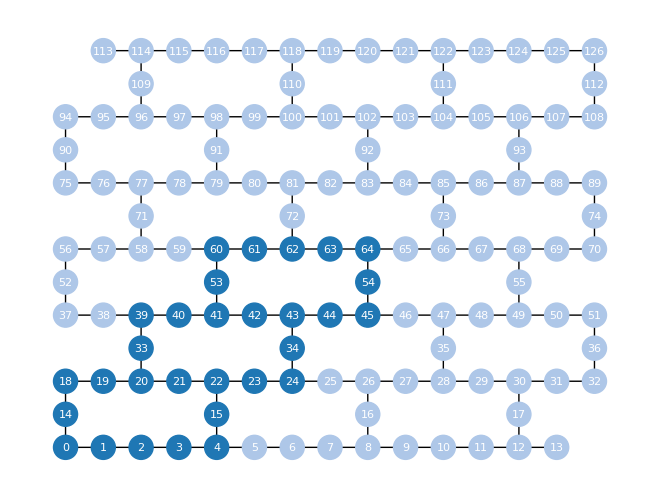

In [37]:
# Sanity Check a Representative Layout
from pyscf import ao2mo
from utils.heartwood import run_active_space_calculation, get_lucj
from utils.visualization import used_qubits, color_batches
from utils.gate_map import plot_gate_map

mc = pyscf.mcscf.CASCI(mf_opt, ncas=norb, nelecas=ne_act).PCM(cm)
mc.with_solvent.method = mf_opt.with_solvent.method  #  Here was make sure that mc is also using the same solvent method defined earlier (IEF-PCM)
mc.with_solvent.eps = mf_opt.with_solvent.eps # Set the dielectric paramters
mc.mo_coeff = mo_avas.copy() # Update the molecular orbitals to include those computed in the presence of the solvent

h1e_cas, ecore = mc.get_h1eff() # <-- h1eff is the 1-electron hamiltonian integrals. h1e_cas is a common alias. ecore is the electronic energy from the core orbitals.
h2e_cas = ao2mo.restore(1, mc.get_h2eff(), norb) # <-- get the 2-electron hamiltonian integrals

mc.mo_coeff, t1, t2 = run_active_space_calculation(h1e_cas, h2e_cas, norb, ne_act, mo_avas.copy(), mf_opt.mol.nelectron//2, ecore)
circuit = get_lucj(norb, num_elec_a, num_elec_b, t1, t2, n_reps=1)
isa_circuit = pass_manager.run(circuit)

qubits = used_qubits(isa_circuit, include={"unitary"})
qcolors = color_batches([set(qubits), set(qubits)^set(range(0, backend.configuration().n_qubits))])
plot_gate_map(backend, label_qubits=True, qubit_color=qcolors, line_color=["black" for _ in backend.coupling_map.get_edges()])

### User controls 
Systematically vary these parameters to improve hardware results.


In [38]:
# Set to "True" to run on real QPU hardware
# Set to "False" to sample from a uniform distribution on classical hardware (useful for parameter debugging)
# If you do not submit results from real Quantum Hardware, you will receive zero points for the section!
# PROMPT:
use_hardware = True

# Error Suppression/Mitigation Options
# >> Configure within at Sampler Primitive

# Transpiler Options
# PROMPT:
optimization_level = 3

# Heartwood Algorithm Options
# PROMPT:
n_iter = 3  # How many update loops to run
resample = 1 # (resample=1 -> resample the QPU after every update loop; resample=n_iter -> sample QPU only once)
shots = 1024 # <-- Get reasonable shots from Figure 5 (REF: Implicit Solvent Sample-Based Quantum Diagonalization)

# SQD Options
# PROMPT:
energy_tol = 1e-5
occupancies_tol = 1e-3 
max_iterations = 100

# Eigenstate Solver Options
# PROMPT:
num_batches = 10
samples_per_batch = 100
carryover_threshold = 0.01
symmetrize_spin = True
max_cycle = 100

# Classical Post-Processing Options
# PROMPT:
mem = 4  # Memory allocated to each parallel Serverless worker (Gb)

In [39]:
# The Heartwood Algorithm
import time
import numpy as np

from qiskit_ibm_runtime import Session, SamplerV2 as Sampler
from qiskit_addon_sqd.counts import generate_bit_array_uniform
from pyscf import ao2mo

from utils.heartwood import run_active_space_calculation, update_rdm, get_lucj, classically_diagonalize

# TIP: Decide if running the hardware jobs in the Session qiskit_ibm_runtime primitive will help, 
# given the time constraint vs parameter exploration tradeoff that you must navigate in the challenge

# Sampler Primitive Options 
sampler = Sampler(mode=backend)
sampler.options.max_execution_time = 30 # Don't change this unless you are confident that you should

# Explore error suppression techniques
# sampler.options.dynamical_decoupling.enable = '<XXX>'
# sampler.options.dynamical_decoupling.sequence_type = '<XXX>'
# sampler.options.twirling.enable_measure = '<XXX>'
# sampler.options.twirling.enable_gates = '<XXX>'
# sampler.options.twirling.num_randomizations = '<XXX>'
# sampler.options.twirling.shots_per_randomization = '<XXX>'

# initial approximation for rdm1
with_solvent_e, with_solvent_v = None, None # Don't touch
data = []
for iiter in range(n_iter):
    print(f">>>>> IMPLICIT SOLVENT ITERATION {iiter+1}/{n_iter}")
    if with_solvent_v is not None: 
        # Subsequent update loops enter here
        mc.get_hcore = lambda *args: mc._scf.get_hcore() + with_solvent_v
    else: 
        # First update loop starts here
        # hcore is the CAS space (classically computed) 1-electron hamiltonian, which we default to at the start of the routine.
        mc.get_hcore = lambda *args: mc._scf.get_hcore() # REF: https://pyscf.org/pyscf_api_docs/pyscf.mcscf.html#pyscf.scf.hf.CASBase.get_h1cas

    # Alias mapping
    # hcore : h1e_cas : h1e_eff
    # nuclear_repulsion_energy : ecore
    # eri : h2e_cas : h2e_eff

    h1e_cas, ecore = mc.get_h1eff() # <-- h1eff is the 1-electron hamiltonian integrals. h1e_cas is a common alias. ecore is the electronic energy from the core orbitals.
    h2e_cas = ao2mo.restore(1, mc.get_h2eff(), norb) # <-- get the 2-electron hamiltonian integrals

    mc.mo_coeff, t1, t2 = run_active_space_calculation(h1e_cas, 
                                                        h2e_cas, 
                                                        norb, 
                                                        ne_act, 
                                                        mo_avas.copy(), 
                                                        mf_opt.mol.nelectron//2, 
                                                        ecore)

    if use_hardware == True:
        if iiter % resample == 0: # <-- Toggle how often you refresh your bitstrings here. The developer suggests that you do it every time, but benevolently provides the freedom to disagree with him via the resample control variable.
            # The "Quantum-Centric" part
            print(">>>>> GENERATING BITSTRINGS USING QUANTUM HARDWARE")
            # LUCJ Ansatz construction
            circuit = get_lucj(norb, num_elec_a, num_elec_b, t1, t2, n_reps=1)

            print(f">>>>> TRANSPILING LUCJ TO {backend.name}")
            isa_circuit = pass_manager.run(circuit)
            print(f">>>>> SUBMITTING ISA_CIRCUIT TO {backend.name}")
            job = sampler.run([isa_circuit], shots=shots) # <----- Error Suppression/Mitigation configured performed upstream
            job_id = str(job.job_id())

            timer = 0
            while job.status() != "DONE":
                timer+=10
                print(f">>>>> [{timer}s] RUNTIME JOB {job_id}: {job.status()}")
                time.sleep(10)

            primitive_result = job.result()
            print(f">>>>> RETRIEVED {job_id} FROM {backend.name}")

            pub_result = primitive_result[0]
            bit_array = pub_result.data.meas

    else:
        print(">>>>> GENERATING BITSTRINGS CLASSICALLY")
        rng = np.random.default_rng(24)
        bit_array = generate_bit_array_uniform(100_000, 2*norb, rand_seed=rng) # <-- Sample bitstrings from a uniform distribution. This is useful for debug, but runs out of steam on large-systems
        job_id = float("nan") # <-- we will check that valid job_id's were passed during grading

    # The "Classical Post-processing" part
    result = classically_diagonalize(bit_array=bit_array, 
                                    nuclear_repulsion_energy=ecore,           # Electronic energy from the core orbitals
                                    hcore=h1e_cas,                            # 1-electron hamiltonian integrals
                                    eri=h2e_cas,                              # 2-electron hamiltonian integrals
                                    num_orbitals=norb,                        # Number of spatial orbitals
                                    nelec=ne_act,                             # Number of electrons
                                    num_elec_a=ne_act//2,                     # Alpha orbitals
                                    num_elec_b=ne_act//2,                     # Beta orbitals
                                    job_id=job_id,                            # QPU bitstring Job ID
                                    client=client,                            # Diagonalization engine worker
                                    energy_tol=energy_tol,                    # SQD option
                                    occupancies_tol=occupancies_tol,          # SQD option
                                    max_iterations=max_iterations,            # SQD option
                                    num_batches=num_batches,                  # Eigenstate solver option
                                    samples_per_batch=samples_per_batch,      # Eigenstate solver option
                                    symmetrize_spin=symmetrize_spin,          # Eigenstate solver option
                                    carryover_threshold=carryover_threshold,  # Eigenstate solver option
                                    max_cycle=max_cycle,                      # Eigenstate solver option
                                    mem=mem,                                  # Memory per Worker (Gb)
                                    )

    # e   : SQD-based estimate of the energy
    # rdm1: Spin-summed 1-particle reduced density matrix
    e, rdm1 = result[0], result[1]
    rho_approximation = update_rdm(mc, rdm1).copy() # <--- Reconstruct the one-body density matrix in the atomic orbital basis to update the external potential due to the solvent

    if with_solvent_e is not None:
        # Subsequent update loops enter here
        edup = np.einsum('ij,ji->', with_solvent_v, rho_approximation) # <-- edup: Incrementing the energy calculation with subsequent iterations
        e += ecore + with_solvent_e - edup

    else:
        # First update loop enters here
        e += ecore # Pulled from the CAS space object (molecule's core energy)

    # Outputs:
    # with_solvent_e : scalar energy correction due to solvent polarization
    # with_solvent_v : Fock-like matrix to be added to the core Hamiltonian in SCF
    with_solvent_e, with_solvent_v = mc.with_solvent._get_vind(rho_approximation)
    data.append((iiter, float(e), job_id))
    print(f">>>>> END IITER {iiter}")
    print(f">>>>> TOTAL ENERGY: {e}\n")

>>>>> IMPLICIT SOLVENT ITERATION 1/3
>>>>> ACTIVE SPACE CALCULATIONS 
Parsing as_fcidump_20:06:52.txt
converged SCF energy = -95.1699725765332
>>>>> RUNNING CCSD
E(CCSD) = -95.29559921589414  E_corr = -0.1256266393609794


Pass: Decompose - 3.10421 (ms)Pass: MergeOrbitalRotations - 1.93381 (ms)Pass: UnitarySynthesis - 0.02575 (ms)Pass: HighLevelSynthesis - 24.04523 (ms)Pass: BasisTranslator - 0.22054 (ms)Pass: ElidePermutations - 0.02646 (ms)Pass: RemoveDiagonalGatesBeforeMeasure - 0.04601 (ms)Pass: RemoveIdentityEquivalent - 0.11587 (ms)Pass: InverseCancellation - 0.11826 (ms)Pass: ContractIdleWiresInControlFlow - 0.01407 (ms)Pass: CommutativeCancellation - 0.57721 (ms)Pass: ConsolidateBlocks - 3.97038 (ms)Pass: Split2QUnitaries - 0.02170 (ms)Pass: SetLayout - 0.10991 (ms)Pass: FullAncillaAllocation - 0.58579 (ms)Pass: EnlargeWithAncilla - 0.18048 (ms)Pass: ApplyLayout - 0.92411 (ms)Pass: CheckMap - 0.22340 (ms)Pass: BarrierBeforeFinalMeasurements - 0.37360 (ms)Pass: SabreSwap - 10.68115 (ms)Pass: FilterOpNodes - 0.44250 (ms)Pass: UnitarySynthesis - 0.02408 (ms)Pass: HighLevelSynthesis - 0.16856 (ms)Pass: BasisTranslator - 9.19199 (ms)Pass: Depth - 1.61195 (ms)Pass: Size - 0.02313 (ms)Pass: MinimumPoint

>>>>> UPDATED t1, t2 PARAMETERS
>>>>> GENERATING BITSTRINGS USING QUANTUM HARDWARE
>>>>> CONSTRUCTING LUCJ CIRCUIT
>>>>> TRANSPILING LUCJ TO ibm_brussels


Pass: ContractIdleWiresInControlFlow - 0.01025 (ms)Pass: GatesInBasis - 0.69165 (ms)Pass: Depth - 0.64898 (ms)Pass: Size - 0.01836 (ms)Pass: MinimumPoint - 0.95081 (ms)Pass: ConsolidateBlocks - 5.60236 (ms)Pass: UnitarySynthesis - 4.61316 (ms)Pass: RemoveIdentityEquivalent - 0.26798 (ms)Pass: Optimize1qGatesDecomposition - 2.56181 (ms)Pass: CommutativeCancellation - 2.45309 (ms)Pass: ContractIdleWiresInControlFlow - 0.01121 (ms)Pass: GatesInBasis - 0.95296 (ms)Pass: Depth - 0.67902 (ms)Pass: Size - 0.01645 (ms)Pass: MinimumPoint - 1.23739 (ms)Pass: ConsolidateBlocks - 9.69052 (ms)Pass: UnitarySynthesis - 2.85220 (ms)Pass: RemoveIdentityEquivalent - 0.28443 (ms)Pass: Optimize1qGatesDecomposition - 2.48861 (ms)Pass: CommutativeCancellation - 2.59852 (ms)Pass: ContractIdleWiresInControlFlow - 0.01073 (ms)Pass: GatesInBasis - 0.65541 (ms)Pass: Depth - 0.58794 (ms)Pass: Size - 0.02122 (ms)Pass: MinimumPoint - 1.21188 (ms)Pass: ConsolidateBlocks - 5.50842 (ms)Pass: UnitarySynthesis - 2.59280

>>>>> SUBMITTING ISA_CIRCUIT TO ibm_brussels
>>>>> [10s] RUNTIME JOB d5cllfg68cgs73cam870: QUEUED
>>>>> RETRIEVED d5cllfg68cgs73cam870 FROM ibm_brussels
>>>>> STARTING DIAGONALIZATION ENGINE 
>>>>> SQD ITERATION 1
>>>>> SUBSAMPLE 0
>>>>> 	ENERGY: -93.75499691500897
>>>>> 	SUBSPACE DIMENSION: 7744
>>>>> SUBSAMPLE 1
>>>>> 	ENERGY: -93.75499691500897
>>>>> 	SUBSPACE DIMENSION: 7744
>>>>> SUBSAMPLE 2
>>>>> 	ENERGY: -93.75499691500897
>>>>> 	SUBSPACE DIMENSION: 7744
>>>>> SUBSAMPLE 3
>>>>> 	ENERGY: -93.75499691500897
>>>>> 	SUBSPACE DIMENSION: 7744
>>>>> SUBSAMPLE 4
>>>>> 	ENERGY: -93.75499691500897
>>>>> 	SUBSPACE DIMENSION: 7744
>>>>> SUBSAMPLE 5
>>>>> 	ENERGY: -93.75499691500897
>>>>> 	SUBSPACE DIMENSION: 7744
>>>>> SUBSAMPLE 6
>>>>> 	ENERGY: -93.75499691500897
>>>>> 	SUBSPACE DIMENSION: 7744
>>>>> SUBSAMPLE 7
>>>>> 	ENERGY: -93.75499691500897
>>>>> 	SUBSPACE DIMENSION: 7744
>>>>> SUBSAMPLE 8
>>>>> 	ENERGY: -93.75499691500897
>>>>> 	SUBSPACE DIMENSION: 7744
>>>>> SUBSAMPLE 9
>>>>> 	ENERG

Pass: Decompose - 2.52128 (ms)Pass: MergeOrbitalRotations - 1.72758 (ms)Pass: UnitarySynthesis - 0.02384 (ms)Pass: HighLevelSynthesis - 26.65496 (ms)Pass: BasisTranslator - 0.18644 (ms)Pass: ElidePermutations - 0.01597 (ms)Pass: RemoveDiagonalGatesBeforeMeasure - 0.03219 (ms)Pass: RemoveIdentityEquivalent - 0.08702 (ms)Pass: InverseCancellation - 0.12064 (ms)Pass: ContractIdleWiresInControlFlow - 0.01025 (ms)Pass: CommutativeCancellation - 0.44799 (ms)Pass: ConsolidateBlocks - 3.04198 (ms)Pass: Split2QUnitaries - 0.01597 (ms)Pass: SetLayout - 0.12159 (ms)Pass: FullAncillaAllocation - 0.54240 (ms)Pass: EnlargeWithAncilla - 0.21601 (ms)Pass: ApplyLayout - 1.26100 (ms)Pass: CheckMap - 0.22030 (ms)Pass: BarrierBeforeFinalMeasurements - 0.38958 (ms)Pass: SabreSwap - 6.42490 (ms)Pass: FilterOpNodes - 0.50068 (ms)Pass: UnitarySynthesis - 0.02956 (ms)Pass: HighLevelSynthesis - 0.15688 (ms)Pass: BasisTranslator - 10.30397 (ms)Pass: Depth - 1.35183 (ms)Pass: Size - 0.02360 (ms)Pass: MinimumPoint

>>>>> TRANSPILING LUCJ TO ibm_brussels


Pass: ConsolidateBlocks - 9.00102 (ms)Pass: UnitarySynthesis - 3.53265 (ms)Pass: RemoveIdentityEquivalent - 0.48637 (ms)Pass: Optimize1qGatesDecomposition - 3.34883 (ms)Pass: CommutativeCancellation - 2.48837 (ms)Pass: ContractIdleWiresInControlFlow - 0.01669 (ms)Pass: GatesInBasis - 0.70977 (ms)Pass: Depth - 0.66757 (ms)Pass: Size - 0.01812 (ms)Pass: MinimumPoint - 0.02742 (ms)Pass: ConsolidateBlocks - 7.39837 (ms)Pass: UnitarySynthesis - 2.90084 (ms)Pass: RemoveIdentityEquivalent - 0.25153 (ms)Pass: Optimize1qGatesDecomposition - 2.32172 (ms)Pass: CommutativeCancellation - 2.65908 (ms)Pass: ContractIdleWiresInControlFlow - 0.01311 (ms)Pass: GatesInBasis - 0.63658 (ms)Pass: Depth - 0.97251 (ms)Pass: Size - 0.02146 (ms)Pass: MinimumPoint - 0.02837 (ms)Pass: ConsolidateBlocks - 9.57036 (ms)Pass: UnitarySynthesis - 2.63238 (ms)Pass: RemoveIdentityEquivalent - 0.22745 (ms)Pass: Optimize1qGatesDecomposition - 2.23446 (ms)Pass: CommutativeCancellation - 2.38252 (ms)Pass: ContractIdleWiresIn

>>>>> SUBMITTING ISA_CIRCUIT TO ibm_brussels
>>>>> [10s] RUNTIME JOB d5cln1m4g4ls73aiv7cg: QUEUED
>>>>> RETRIEVED d5cln1m4g4ls73aiv7cg FROM ibm_brussels
>>>>> STARTING DIAGONALIZATION ENGINE 
>>>>> SQD ITERATION 1
>>>>> SUBSAMPLE 0
>>>>> 	ENERGY: -92.21677632089543
>>>>> 	SUBSPACE DIMENSION: 5625
>>>>> SUBSAMPLE 1
>>>>> 	ENERGY: -92.21677632089543
>>>>> 	SUBSPACE DIMENSION: 5625
>>>>> SUBSAMPLE 2
>>>>> 	ENERGY: -92.21677632089543
>>>>> 	SUBSPACE DIMENSION: 5625
>>>>> SUBSAMPLE 3
>>>>> 	ENERGY: -92.21677632089543
>>>>> 	SUBSPACE DIMENSION: 5625
>>>>> SUBSAMPLE 4
>>>>> 	ENERGY: -92.21677632089543
>>>>> 	SUBSPACE DIMENSION: 5625
>>>>> SUBSAMPLE 5
>>>>> 	ENERGY: -92.21677632089543
>>>>> 	SUBSPACE DIMENSION: 5625
>>>>> SUBSAMPLE 6
>>>>> 	ENERGY: -92.21677632089543
>>>>> 	SUBSPACE DIMENSION: 5625
>>>>> SUBSAMPLE 7
>>>>> 	ENERGY: -92.21677632089543
>>>>> 	SUBSPACE DIMENSION: 5625
>>>>> SUBSAMPLE 8
>>>>> 	ENERGY: -92.21677632089543
>>>>> 	SUBSPACE DIMENSION: 5625
>>>>> SUBSAMPLE 9
>>>>> 	ENERG

Pass: Decompose - 2.55227 (ms)Pass: MergeOrbitalRotations - 1.81293 (ms)Pass: UnitarySynthesis - 0.02551 (ms)Pass: HighLevelSynthesis - 24.83177 (ms)Pass: BasisTranslator - 0.26822 (ms)Pass: ElidePermutations - 0.01955 (ms)Pass: RemoveDiagonalGatesBeforeMeasure - 0.04125 (ms)Pass: RemoveIdentityEquivalent - 0.10920 (ms)Pass: InverseCancellation - 0.11301 (ms)Pass: ContractIdleWiresInControlFlow - 0.05817 (ms)Pass: CommutativeCancellation - 0.62752 (ms)Pass: ConsolidateBlocks - 2.98405 (ms)Pass: Split2QUnitaries - 0.01884 (ms)Pass: SetLayout - 0.08941 (ms)Pass: FullAncillaAllocation - 0.99659 (ms)Pass: EnlargeWithAncilla - 0.24223 (ms)Pass: ApplyLayout - 1.07479 (ms)Pass: CheckMap - 0.25249 (ms)Pass: BarrierBeforeFinalMeasurements - 0.41676 (ms)Pass: SabreSwap - 7.44677 (ms)Pass: FilterOpNodes - 0.67997 (ms)Pass: UnitarySynthesis - 0.02789 (ms)Pass: HighLevelSynthesis - 0.13590 (ms)Pass: BasisTranslator - 10.19764 (ms)Pass: Depth - 1.50084 (ms)Pass: Size - 0.01788 (ms)Pass: MinimumPoint

>>>>> UPDATED t1, t2 PARAMETERS
>>>>> GENERATING BITSTRINGS USING QUANTUM HARDWARE
>>>>> CONSTRUCTING LUCJ CIRCUIT
>>>>> TRANSPILING LUCJ TO ibm_brussels


Pass: Size - 0.01669 (ms)Pass: MinimumPoint - 1.20926 (ms)Pass: ConsolidateBlocks - 5.97358 (ms)Pass: UnitarySynthesis - 3.46422 (ms)Pass: RemoveIdentityEquivalent - 0.25773 (ms)Pass: Optimize1qGatesDecomposition - 2.21491 (ms)Pass: CommutativeCancellation - 2.60615 (ms)Pass: ContractIdleWiresInControlFlow - 0.01478 (ms)Pass: GatesInBasis - 0.67568 (ms)Pass: Depth - 0.76556 (ms)Pass: Size - 0.02027 (ms)Pass: MinimumPoint - 0.98872 (ms)Pass: ConsolidateBlocks - 6.28877 (ms)Pass: UnitarySynthesis - 2.76470 (ms)Pass: RemoveIdentityEquivalent - 0.25368 (ms)Pass: Optimize1qGatesDecomposition - 2.45667 (ms)Pass: CommutativeCancellation - 3.79753 (ms)Pass: ContractIdleWiresInControlFlow - 0.01693 (ms)Pass: GatesInBasis - 0.98777 (ms)Pass: Depth - 1.24884 (ms)Pass: Size - 0.02956 (ms)Pass: MinimumPoint - 0.02837 (ms)Pass: ContainsInstruction - 0.03600 (ms)Pass: InstructionDurationCheck - 0.02217 (ms)base_primitive._run:INFO:2026-01-03 20:15:06,385: Submitting job using options {'options': {}, 

>>>>> SUBMITTING ISA_CIRCUIT TO ibm_brussels
>>>>> [10s] RUNTIME JOB d5clpajgr59c73854mng: QUEUED
>>>>> RETRIEVED d5clpajgr59c73854mng FROM ibm_brussels
>>>>> STARTING DIAGONALIZATION ENGINE 
>>>>> SQD ITERATION 1
>>>>> SUBSAMPLE 0
>>>>> 	ENERGY: -92.26042590075929
>>>>> 	SUBSPACE DIMENSION: 4624
>>>>> SUBSAMPLE 1
>>>>> 	ENERGY: -92.26042590075929
>>>>> 	SUBSPACE DIMENSION: 4624
>>>>> SUBSAMPLE 2
>>>>> 	ENERGY: -92.26042590075929
>>>>> 	SUBSPACE DIMENSION: 4624
>>>>> SUBSAMPLE 3
>>>>> 	ENERGY: -92.26042590075929
>>>>> 	SUBSPACE DIMENSION: 4624
>>>>> SUBSAMPLE 4
>>>>> 	ENERGY: -92.26042590075929
>>>>> 	SUBSPACE DIMENSION: 4624
>>>>> SUBSAMPLE 5
>>>>> 	ENERGY: -92.26042590075929
>>>>> 	SUBSPACE DIMENSION: 4624
>>>>> SUBSAMPLE 6
>>>>> 	ENERGY: -92.26042590075929
>>>>> 	SUBSPACE DIMENSION: 4624
>>>>> SUBSAMPLE 7
>>>>> 	ENERGY: -92.26042590075929
>>>>> 	SUBSPACE DIMENSION: 4624
>>>>> SUBSAMPLE 8
>>>>> 	ENERGY: -92.26042590075929
>>>>> 	SUBSPACE DIMENSION: 4624
>>>>> SUBSAMPLE 9
>>>>> 	ENERG

In [ ]:
# If you make a mistake and need to cancel Serverless jobs
cancel = False
for job in client.jobs():
    print(f"ID {job.job_id}: {job.status()}")
    if cancel:
        job.cancel()

<div class="alert alert-block alert-danger">

### Report your plot

**SQD/IEF-PCM(cc-pVDZ) Energy Convergence Plot**: To assist you in visualizing your final results, we have provided a plotting tool. You must generate a plot for the successfully computed molecule $\textit{using the function provided}$. 

</div>

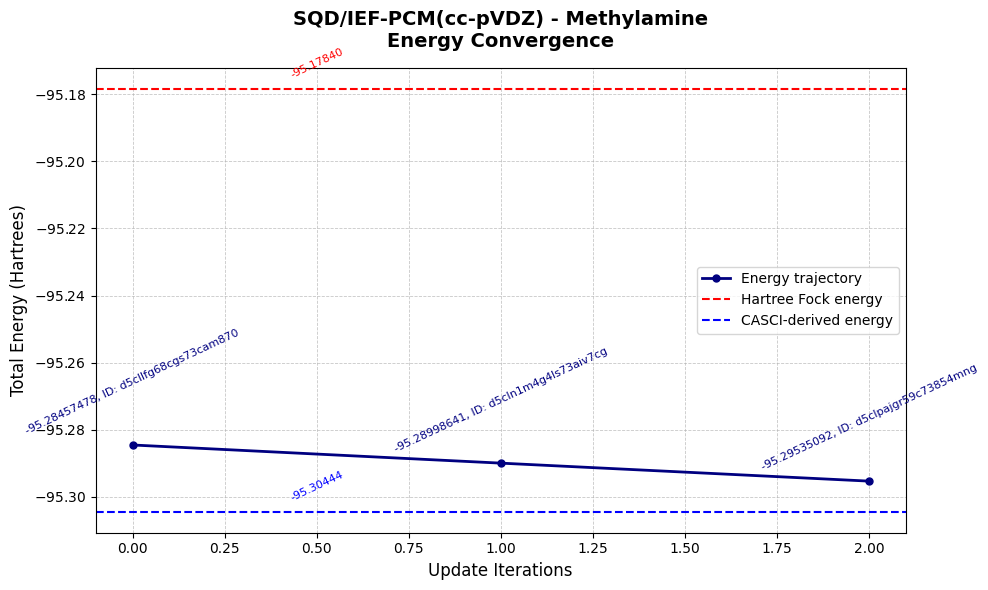

In [40]:
# Plot your data
import matplotlib.pyplot as plt
from utils.visualization import plot_data

fig, ax = plot_data(data, baseline_1=hf_e, baseline_2=CASCI_E, name=molecule_name, save=True)
plt.show()

In [41]:
# Verify your data
print(f"Molecule: {molecule_name}")
print(f"Hartree-Fock Energy: {hf_e}")
print(f"CASCI Energy: {CASCI_E}")
print(f"Hardware Data:\n{data}") # Make sure to include the job_ids' with this data (not doing so will result in disqualification as the winners reported data will be validated against the job_id data)

Molecule: Methylamine
Hartree-Fock Energy: -95.17839586274371
CASCI Energy: -95.30443886330966
Hardware Data:
[(0, -95.28457478470061, 'd5cllfg68cgs73cam870'), (1, -95.28998640564505, 'd5cln1m4g4ls73aiv7cg'), (2, -95.29535092489175, 'd5clpajgr59c73854mng')]


<div class="alert alert-block alert-danger">

### Record your SQD-based results

To report your results, use the function $report\_result()$. You can put your finalized classical energy and quantum energy values for each respective molecule. Make sure to put your answers into the `report_result` function, which will write them to a `results.json` file that will be used to compute your score. If you do not submit results from real quantum hardware, you will receive zero points for the section!

</div>

In [42]:
from utils.helpers import report_result

# Overwrite current data in results.json (be careful, and save a backup file if uncertain)
report_result(molecule_name=molecule_name, hartree_fock_E=hf_e, casci_E=CASCI_E, sqd_E=data)

In [43]:
grader_ch2_ex3(molecule_name, data)

Grading your answer. Please wait...

Congratulations 🎉! Your answer is correct.
Your score is 0.0.


<div class="alert alert-block alert-success">
Good job! You've finished Excercise 3!

Congratulations! You've finished all the problems!
</div>